# Chapter 5

## Intro
+ Multiple regression - using more than 1 predictor variable to model an outcome
+ Why use?:
    + Statistical control for confounds - A confound makes a variable of no real importance seem important.
        + Storks -> babies actually more chimneys - more houses - more stork nests more babies
        + Cities in USA - number of dogs -> number of road traffic accidents
    + Multiple causation Net wealth could be earned , inherited
    + Interaction - where two variables react with each other
![alt text](images/Interaction_plot_stroke_survival.svg.png "Title")


In [1]:
library(rethinking)
library(dagitty)
data(WaffleDivorce)
d <- WaffleDivorce

Loading required package: rstan

Loading required package: StanHeaders

Loading required package: ggplot2

rstan (Version 2.21.5, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Loading required package: cmdstanr

This is cmdstanr version 0.5.2

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- CmdStan path: /home/david/.cmdstan/cmdstan-2.30.0

- CmdStan version: 2.30.0


A newer version of CmdStan is available. See ?install_cmdstan() to install it.
To disable this check set option or environment variable CMDSTANR_NO_VER_CHECK=TRUE.

Loading required package: parallel

rethinking (Version 2.21)


Attaching package: ‘rethinking’


The following object is masked from ‘package:rstan’:

    stan


The following object is masked from ‘package:stats’:

    rstudent




In [2]:
head(d)

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage.SE,Divorce,Divorce.SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>
1,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
2,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
3,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
4,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
5,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00
6,Colorado,CO,5.03,25.7,23.5,1.24,11.6,0.94,11,0,0,34277,0.00


In [3]:
precis(d)

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Location,NaN,NA,NA,NA,
Loc,NaN,NA,NA,NA,
Population,6.119600e+00,6.876156e+00,0.65780,1.897690e+01,▇▃▁▁▁▁▁▁
MedianAgeMarriage,2.605400e+01,1.243630e+00,24.26950,2.826100e+01,▁▁▂▂▃▇▅▃▁▁▂▁▁▁
Marriage,2.011400e+01,3.797905e+00,15.20850,2.649150e+01,▁▃▇▇▇▅▂▁▁▁
Marriage.SE,1.399400e+00,7.969749e-01,0.54950,2.902200e+00,▁▇▅▃▁▂▁▁
Divorce,9.688000e+00,1.820814e+00,6.66950,1.273050e+01,▂▃▅▅▇▂▃▁
Divorce.SE,9.618000e-01,5.253675e-01,0.34085,1.893050e+00,▂▇▇▃▃▂▁▂▂▁▁▁
WaffleHouses,3.234000e+01,6.578959e+01,0.00000,1.357450e+02,▇▁▁▁▁▁▁▁


In [4]:
dim(d)

[1] 50 13

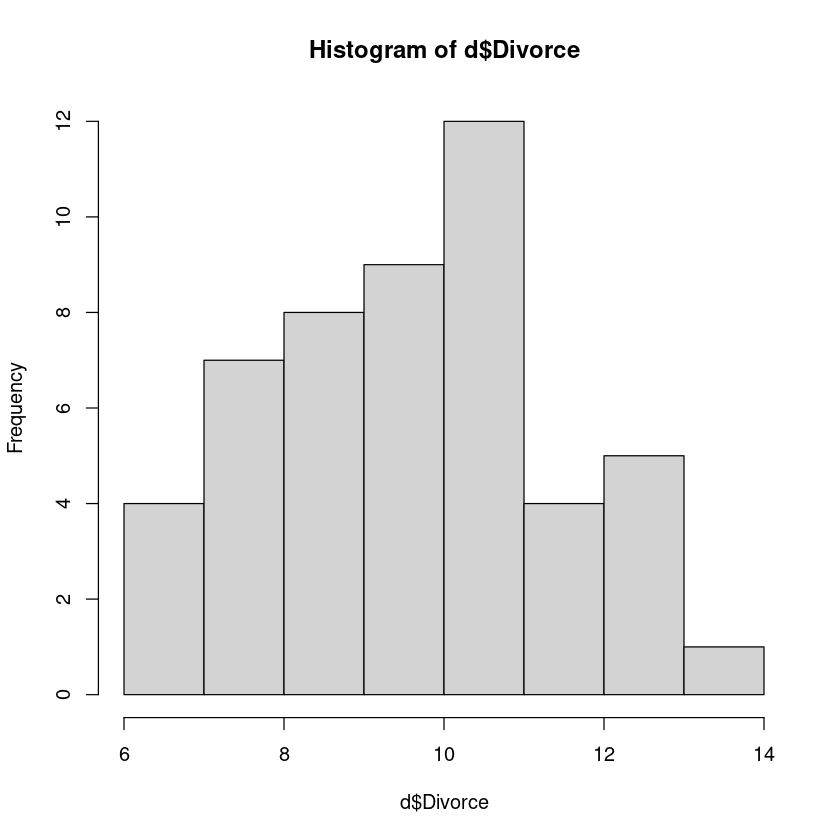

In [5]:
hist(d$Divorce)

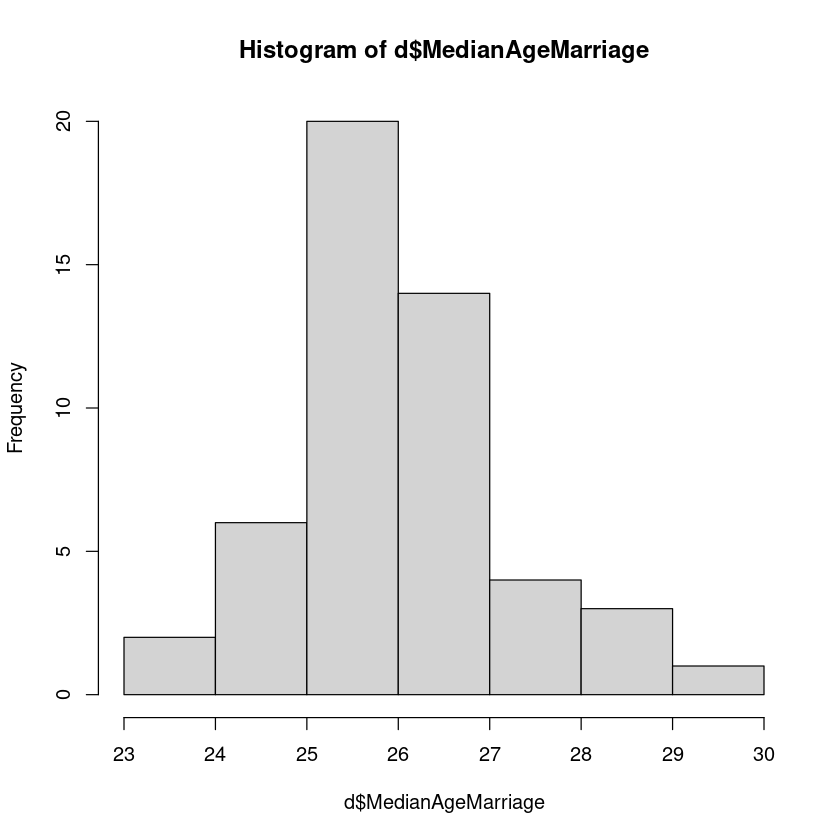

In [6]:
hist(d$MedianAgeMarriage)

In [7]:
d$A <- scale(d$MedianAgeMarriage)
d$D <- scale(d$Divorce)

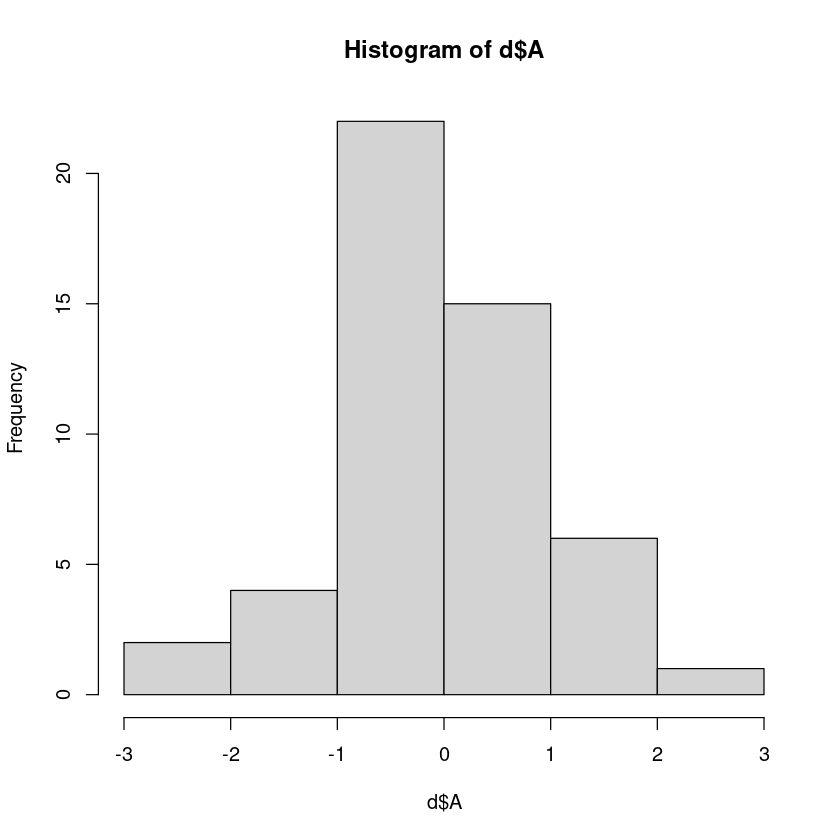

In [8]:
hist(d$A)

In [9]:
# Age 
mean(d$A)
sd(d$A)

[1] 1.027969e-15

[1] 1

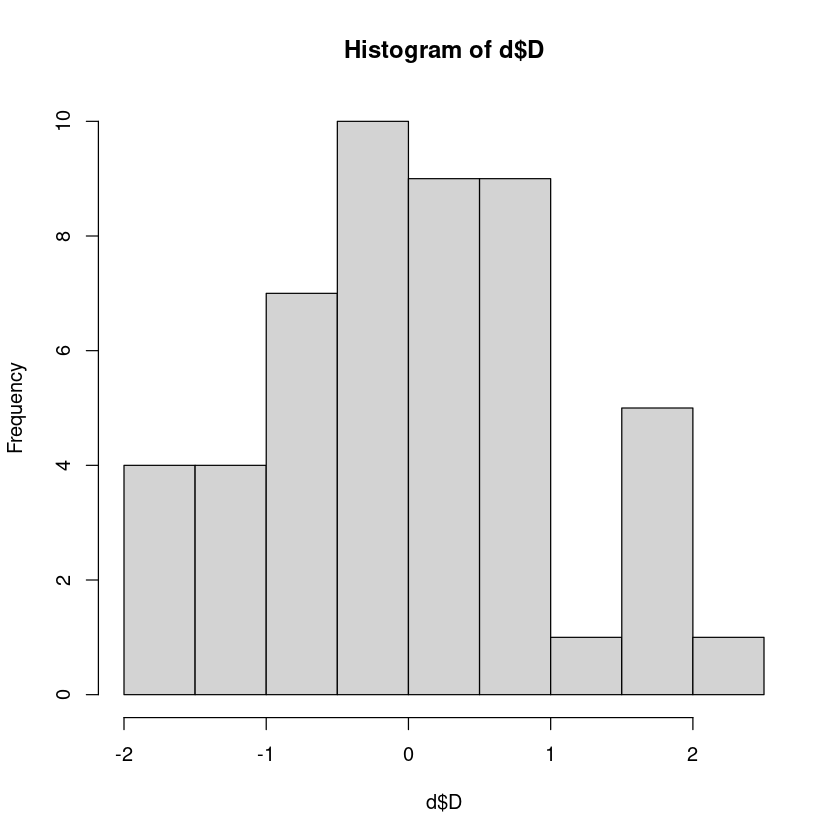

In [10]:
hist(d$D)

In [11]:
# Divorce rate 
mean(d$D)
sd(d$D)

[1] -3.169351e-16

[1] 1

In [12]:
sd(d$MedianAgeMarriage)

[1] 1.24363

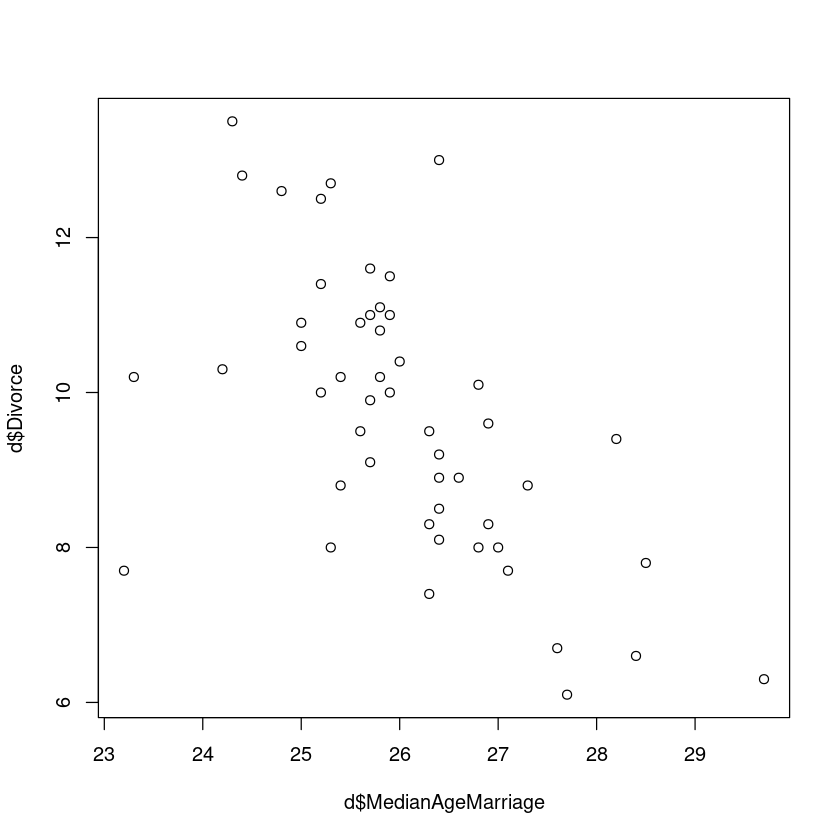

In [13]:
plot(d$MedianAgeMarriage, d$Divorce)

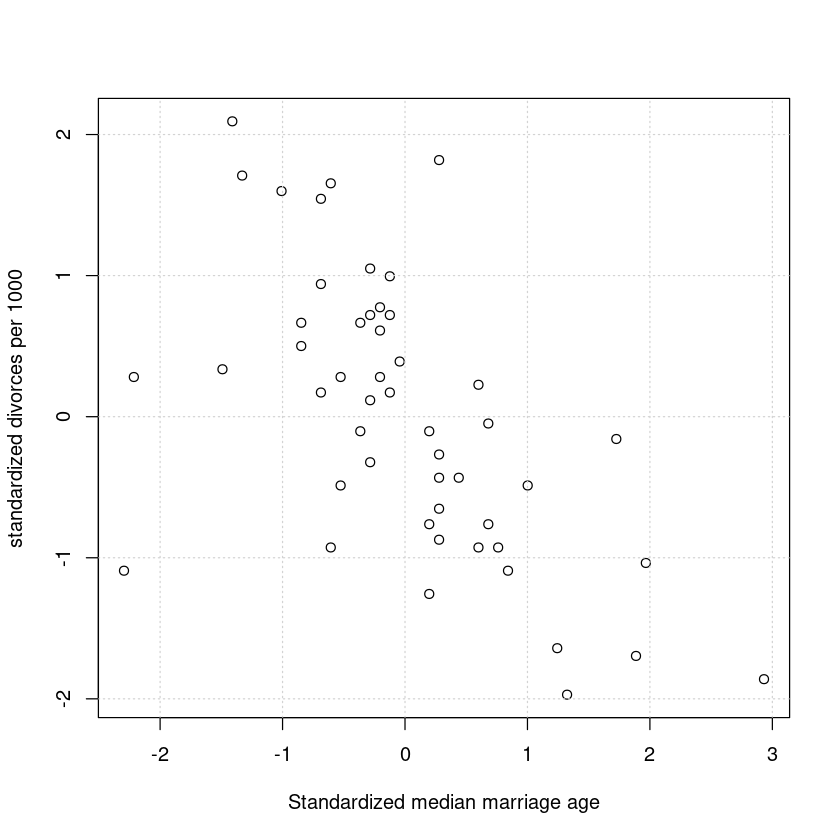

In [14]:
plot(d$A, d$D, xlab='Standardized median marriage age', ylab='standardized divorces per 1000')
# abline(lm(d$A ~ d$D))
grid()

### Model

![alt text](images/model-1.png "Title")

+ line 1 - each state's divorce rate is normally distributed with a mean specific to the state and a common standard deviation sigma (Likelihood)

+ line 2 - the state specific mean = parameter alpha + parameter B_A x median mariage age of that state (linear model)

+ line 3 - parameter alpha is normally distributed centered at 0, with stdev = 0.2 (alpha prior)

+ line 4 - parameter beta is normally distributed centered at 0, with stdev = 0.5 (beta prior)

+ line 5 - common standard deviation sigma is exponentially distributed with param=1 (sigma prior)

### The priors - Working from bottom up

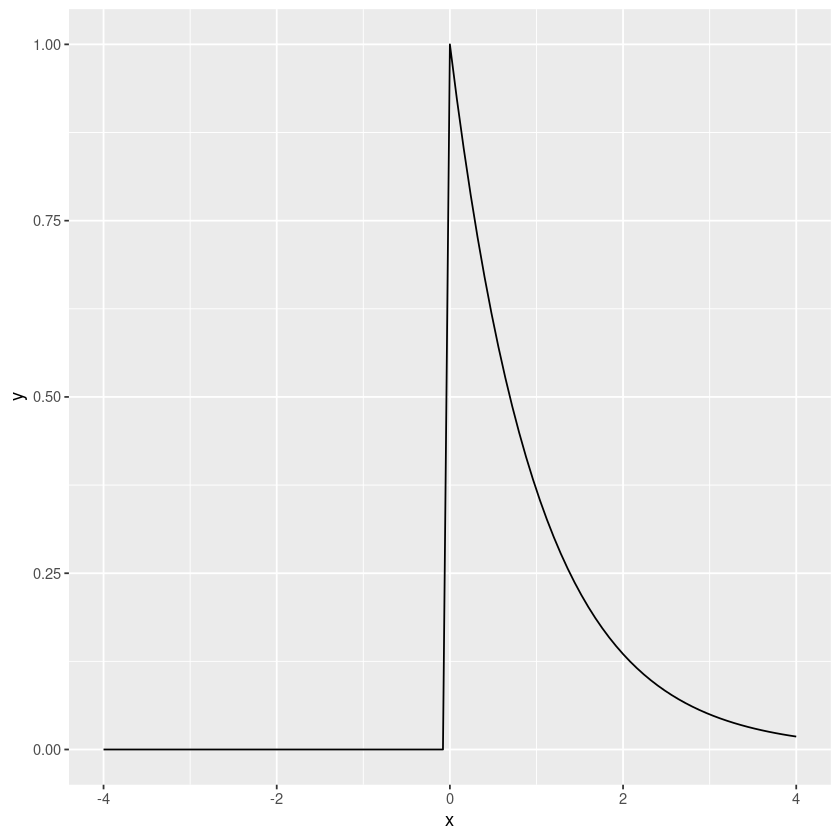

In [15]:
# sigma
ggplot(data.frame(x = c(-4, 4)), aes(x = x)) +
stat_function(fun = dexp, args=c(1.0))

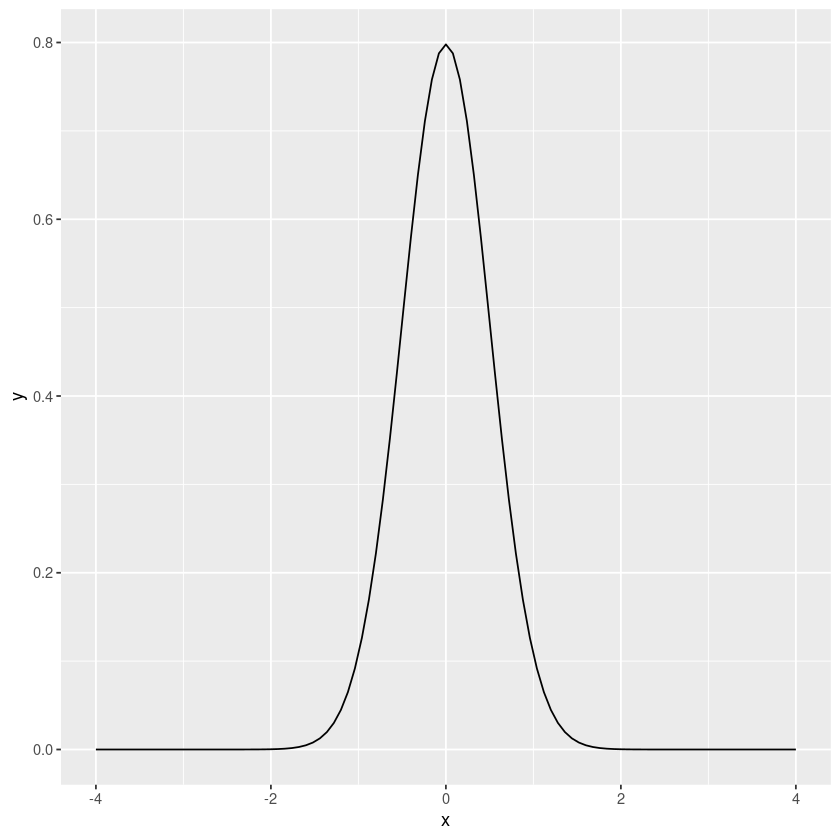

In [16]:
# beta
ggplot(data.frame(x = c(-4, 4)), aes(x = x)) +
stat_function(fun = dnorm, args=c(mean=0.0, sd=0.5))

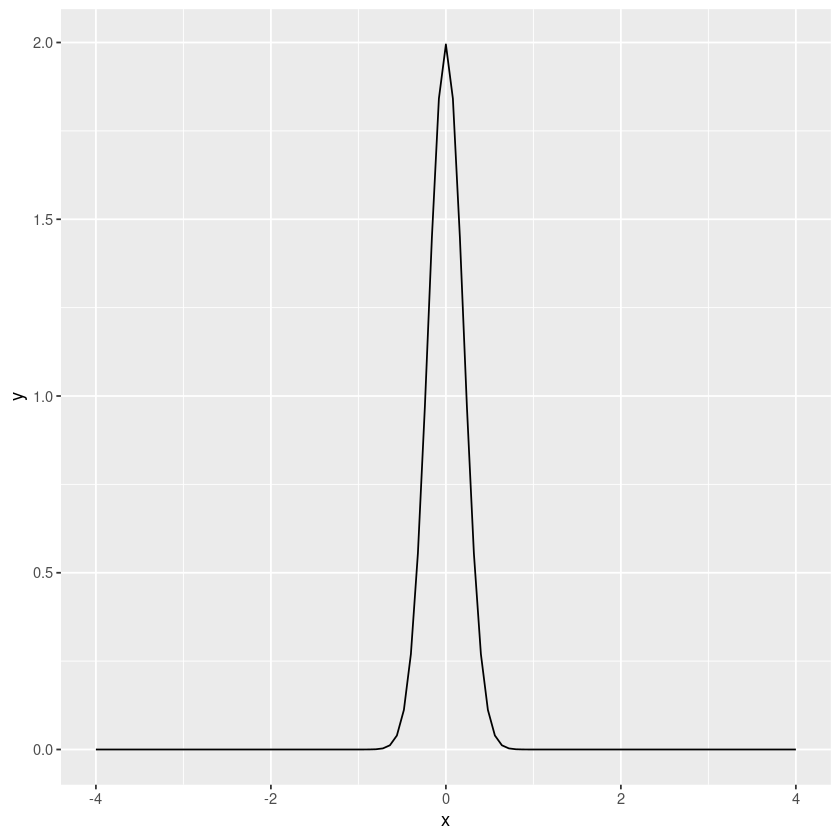

In [17]:
#alpha
ggplot(data.frame(x = c(-4, 4)), aes(x = x)) +
stat_function(fun = dnorm, args=c(mean=0.0, sd=0.2))

![alt text](images/model-1.png "Title")

First - remember we are in standardixed lan

Why those priors?
+ alpha - the intercept - makes sense should be around 0 if plotting 2 standardized distributions against each other
+ beta - this parameter multiplies the state's median marriage age to get the state's divorce rate per 1000.
If beta = 1 then that shifts the median age by 1 standard deviation and the divorce rate by 1 standard deviation. So a change in 1.25 years would mean a change of 1.8 in divorce rate. Divorce rate is between 6 and 14 and is centered around 10.

If beta = 0.5 then that shifts the state's divorce rate by 0.5 standard deviations. So a change in 0.625 years would mean a change of 0.9 in divorce rate. Why is this +/-. Surely the shape of the plot means it has to be minus?

??? This doesn't make sense we are just multiplying a standardized number to get a standardized number???




We know marriage age ranges from 23 to 30 and is centered around 26. The linear fo
rmula is beta x state's median marriage age
    + If beta = 1, then for divorce rate would shift by 1 x 1 = 1 for a state where age 1 year higher than median, would shift by (30 -26) x 1 = 
    + if beta = 2, then divorce rate would shift b

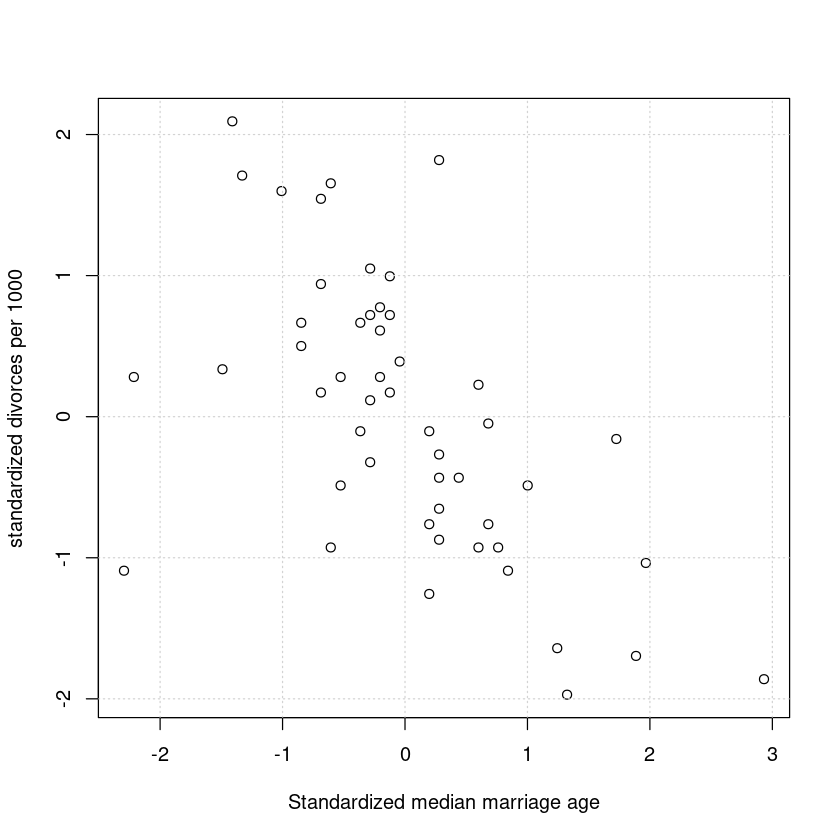

In [18]:
plot(d$A, d$D, xlab='Standardized median marriage age', ylab='standardized divorces per 1000')
# abline(lm(d$A ~ d$D))
grid()

### Model as Code

In [19]:
m5.1 <- quap(
    alist(
        D ~ dnorm(mu, sigma), # likelihood
        mu <- a + bA * A, # linear model
        a ~ dnorm( 0, 0.2), # alpha prior
        bA ~ dnorm(0, 0.5), # beta prior
        sigma ~ dexp(1) # sigma prior
    ), data=d)

+ $D_i ~ Normal(mu_i, sigma)$ - Means the (zero centered, stdev=1) Divorce rate for state i is normally distributed with paramters mu_i, sigma

+ mu <- a + bA + A - $mu_i = alpha + beta_{age}\,x \,age_i$
    + mean divorce rate in a state = base divorce rate (intercept) x factor beta x 

+ a ~ dnorm( 0, 0.2) - alpha is normally distributed centred at 0, with small standard deviation. This means - What is the divorce rate when marriage age is mean of marriage ages?
    + Why? - Because both variables are standardized meaning that the intercept should be around 0


+ bA ~ dnorm(0, 0.5) - beta is normally distributed centred at 0, with stdev=0.5
+ sigma ~ dexp(1) - sigma exponentially distributed parameter = 1

### Simulate priors

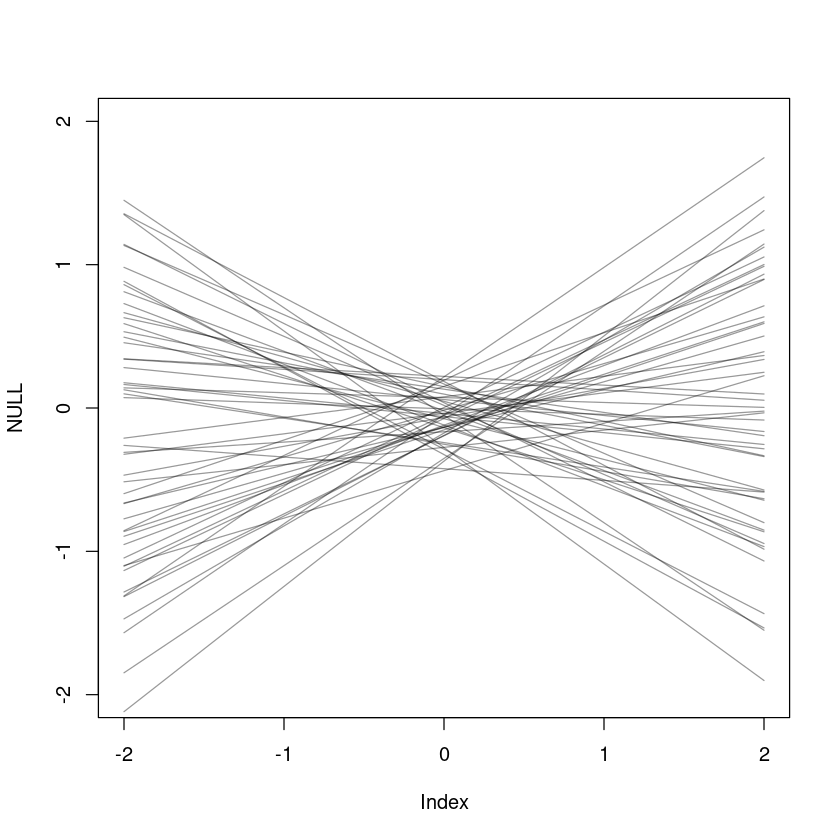

In [20]:
set.seed(10)
prior <- extract.prior(m5.1)
mu <- link(m5.1, post=prior, data=list(A=c(-2,2)))
plot(NULL, xlim=c(-2, 2), ylim=c(-2,2))
for ( i in 1:50) lines(c(-2,2), mu[i,], col=col.alpha("black", 0.4))

### My (better?) priors

In [21]:
m5.1a <- quap(
    alist(
        D ~ dnorm(mu, sigma), # likelihood
        mu <- a + bA * A, # linear model
        a ~ dnorm( 0, 0.2), # alpha prior
        bA ~ dnorm(-1.0, 0.4), # beta prior
        sigma ~ dexp(1) # sigma prior
    ), data=d)

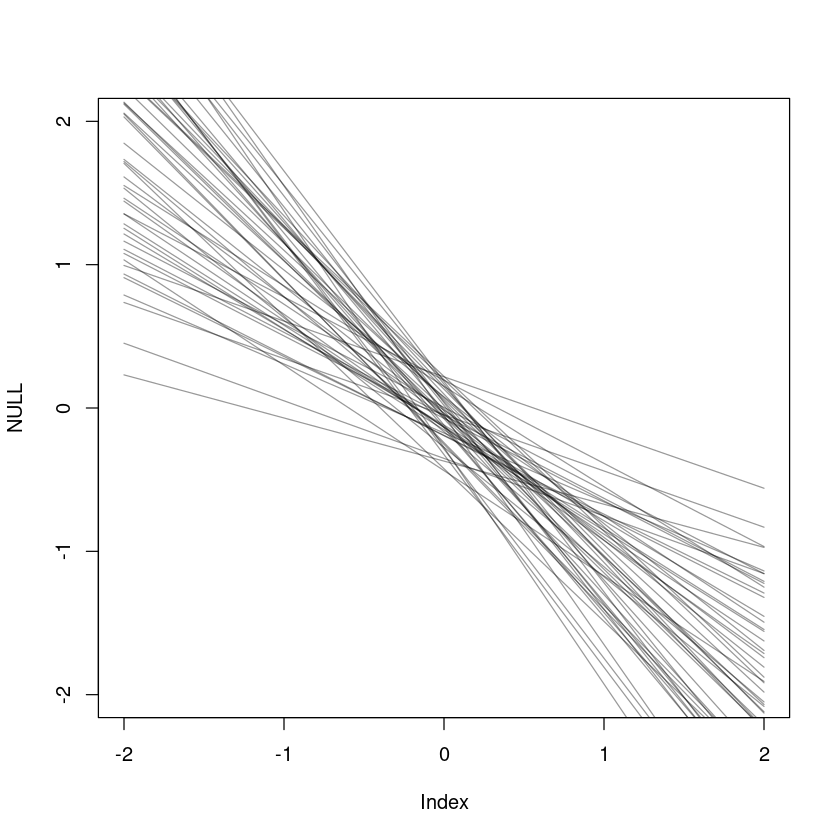

In [22]:
set.seed(10)
prior <- extract.prior(m5.1a)
mu <- link(m5.1, post=prior, data=list(A=c(-2,2)))
plot(NULL, xlim=c(-2, 2), ylim=c(-2,2))
for ( i in 1:50) lines(c(-2,2), mu[i,], col=col.alpha("black", 0.4))

### Posterior Predictions

In [23]:
# compute percentile interval of mean
A_seq <- seq(from=-3, to=3.2, length.out=30)
mu <- link(m5.1, data=list(A=A_seq))
mu.mean <- apply(mu, 2, mean)
mu.PI <- apply(mu, 2, PI)

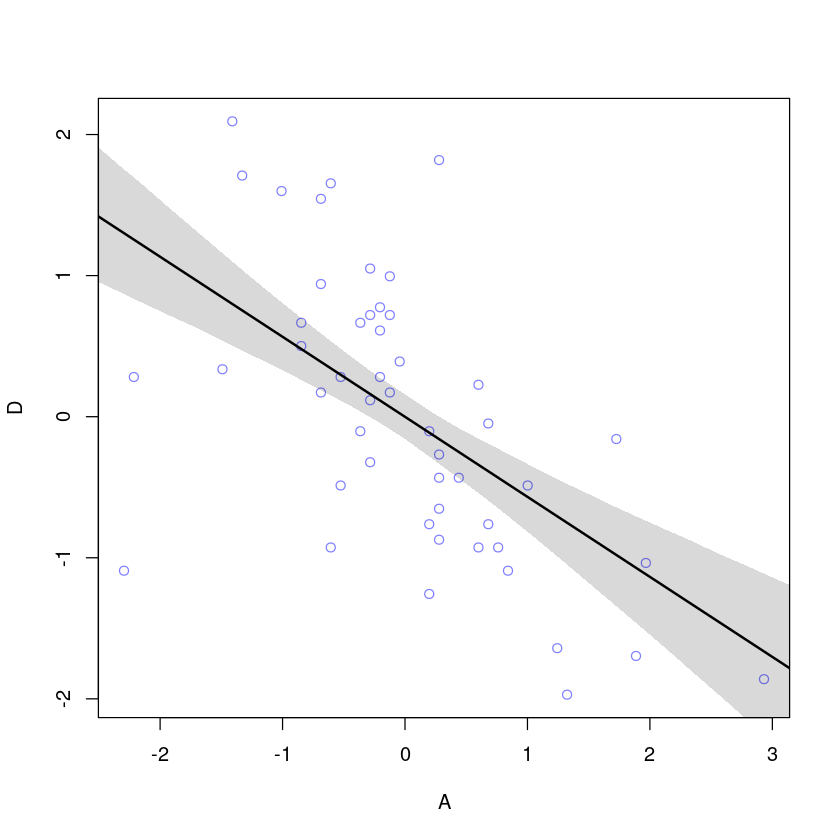

In [24]:
plot(D ~ A, data=d, col=rangi2)
lines(A_seq, mu.mean, lwd=2)
shade(mu.PI, A_seq)

In [25]:
precis(m5.1)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,2.759134e-06,0.09737888,-0.1556275,0.1556330
bA,-5.683974e-01,0.11000001,-0.7441987,-0.3925962
sigma,7.883268e-01,0.07801163,0.6636492,0.9130045


#### using my better priors

In [26]:
# compute percentile interval of mean
A_seq <- seq(from=-3, to=3.2, length.out=30)
mu <- link(m5.1a, data=list(A=A_seq))
mu.mean <- apply(mu, 2, mean)
mu.PI <- apply(mu, 2, PI)

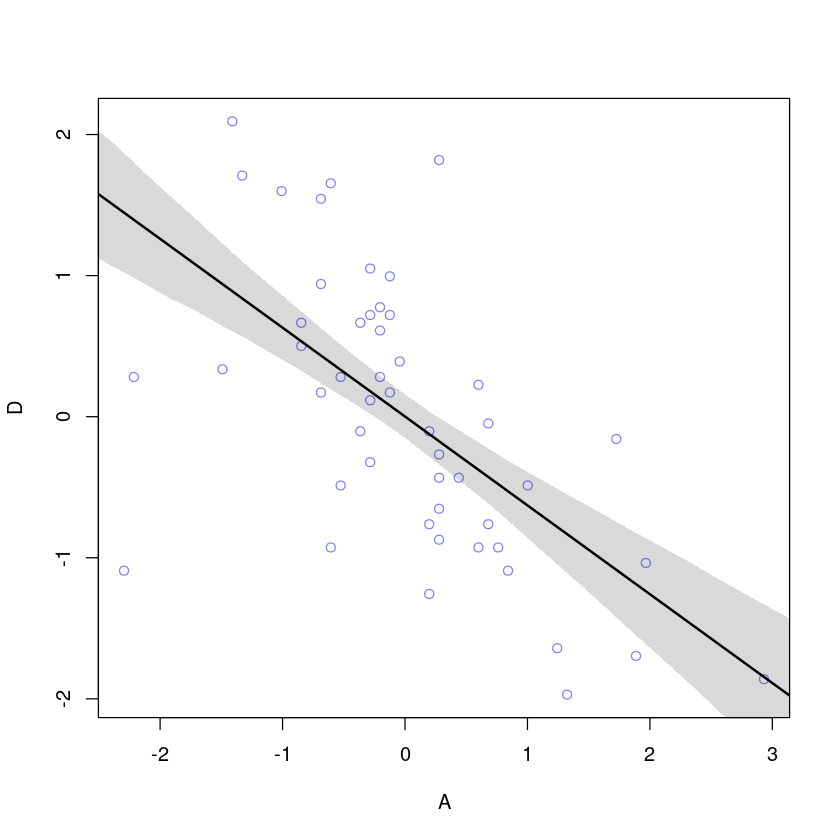

In [27]:
plot(D ~ A, data=d, col=rangi2)
lines(A_seq, mu.mean, lwd=2)
shade(mu.PI, A_seq)

In [28]:
precis(m5.1a)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,4.430189e-06,0.09738231,-0.1556313,0.1556402
bA,-6.268116e-01,0.10854380,-0.8002856,-0.4533377
sigma,7.883633e-01,0.07801900,0.6636739,0.9130527


### Relationship between marriage rate and divorce rate

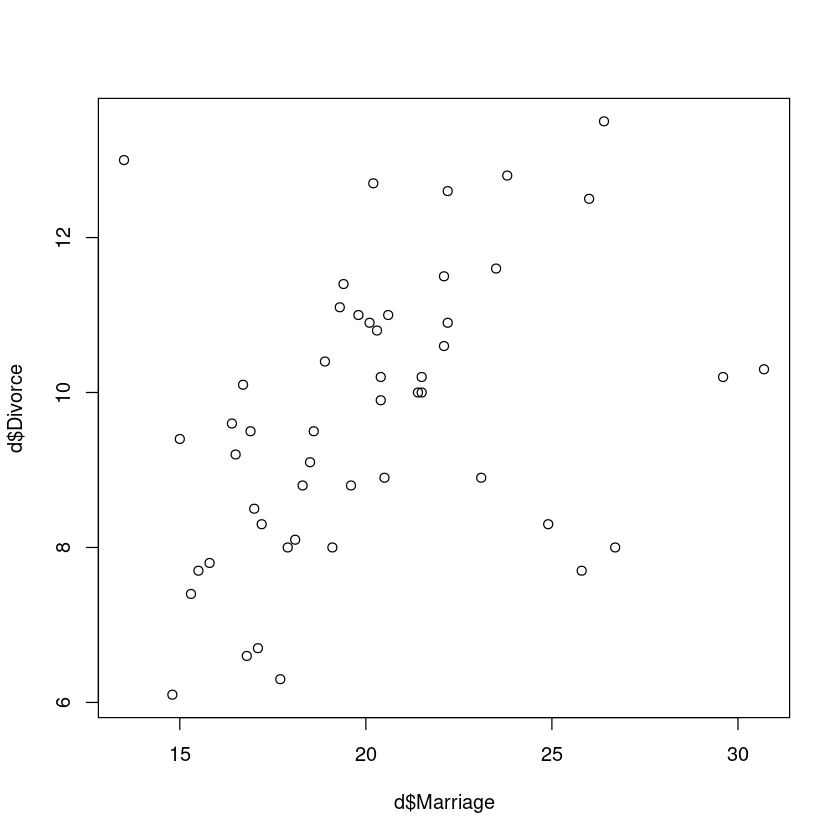

In [29]:
plot(d$Marriage, d$Divorce)

In [30]:
d$M <- scale(d$Marriage)

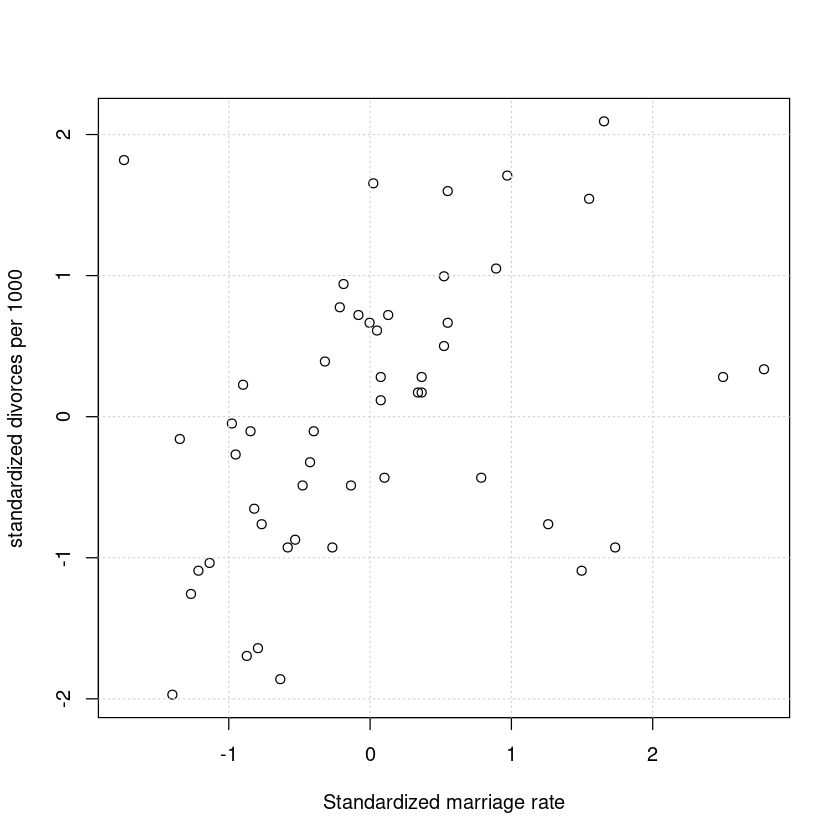

In [31]:
plot(d$M, d$D, xlab='Standardized marriage rate', ylab='standardized divorces per 1000')
# abline(lm(d$A ~ d$D))
grid()

In [32]:
# Note exactly the same priors
m5.2 <- quap(
    alist(
        D ~ dnorm(mu, sigma),
        mu <- a + bM * M,
        a ~ dnorm(0, 0.2),
        bM ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ), data=d)

In [33]:
# compute percentile interval of mean
M_seq <- seq(from=-3, to=3.2, length.out=30)
mu <- link(m5.2, data=list(M=M_seq))
mu.mean <- apply(mu, 2, mean)
mu.PI <- apply(mu, 2, PI)

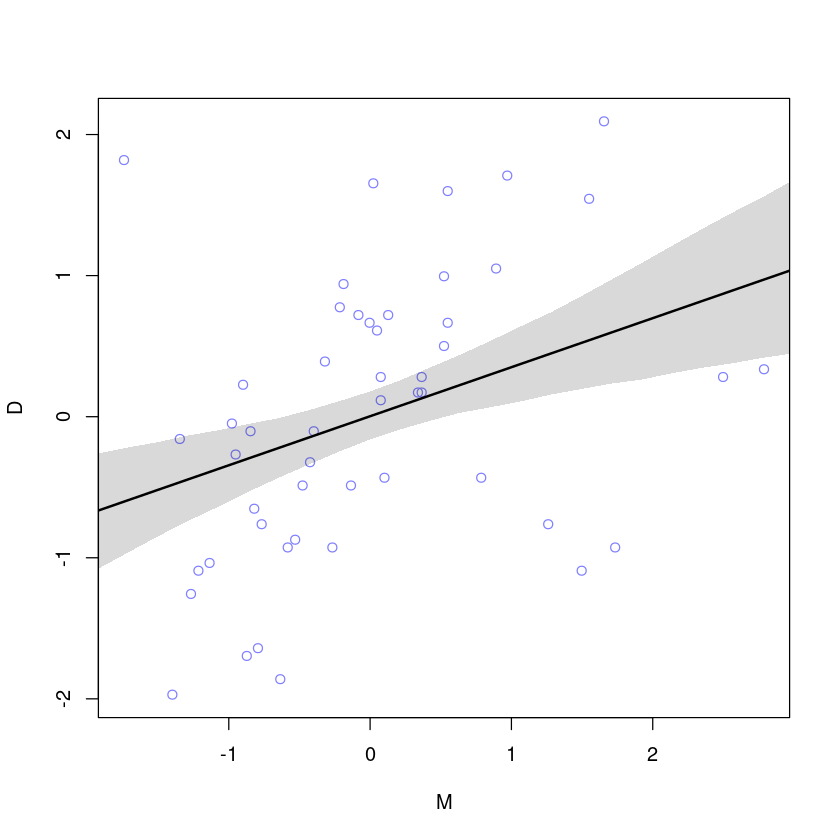

In [34]:
plot(D ~ M, data=d, col=rangi2)
lines(M_seq, mu.mean, lwd=2)
shade(mu.PI, A_seq)

In [35]:
precis(m5.2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,6.689489e-07,0.10824646,-0.1729981,0.1729994
bM,3.500544e-01,0.12592750,0.1487979,0.5513109
sigma,9.102659e-01,0.08986252,0.7666482,1.0538835


+ The relationship is not as strong between marriage rate and divorce rate - the mean of marriage_beta = 0.35
+ The relationship between marriage age and divorce rate is stronger age_beta = = -0.56
+ What do we do?

### Think before you regress
+ DAG
+ Graph means points (nodes) and lines (connections)
+ Directed means connections are directional
+ Acyclic means does not flow back on itself (How can a 3 point graph flow back on itself?)

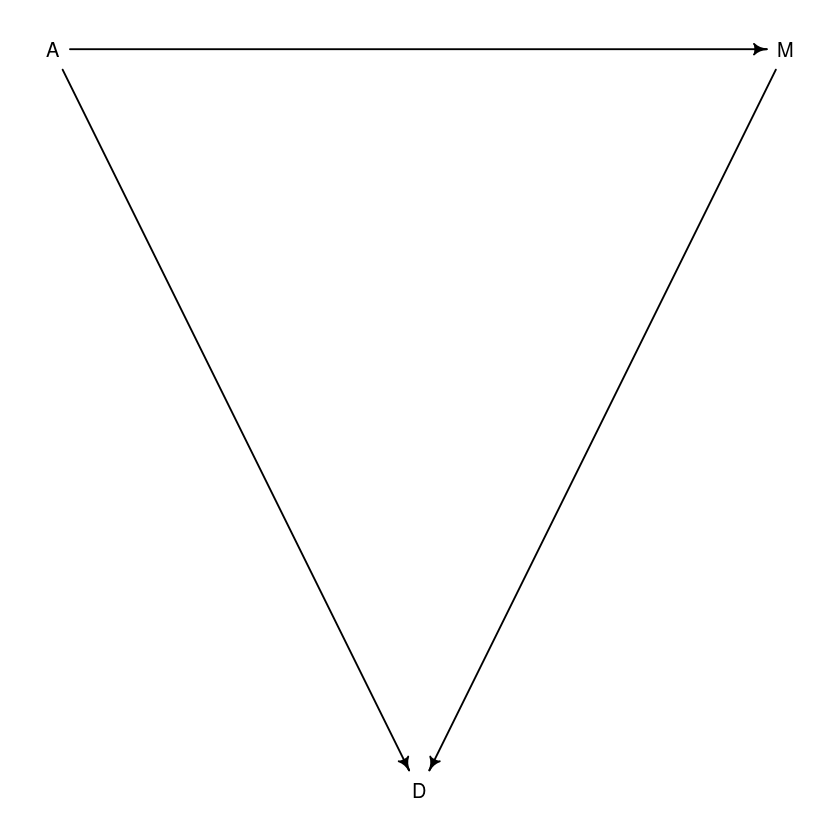

In [36]:
dag5.1 <- dagitty( "dag {
A -> D
A -> M
M -> D
}")
coordinates(dag5.1) <- list( x=c(A=0,D=1,M=2) , y=c(A=0,D=1,M=0) )
drawdag( dag5.1 )

+ A directly influences D marriage age directly influences divorce rate
+ M directly influences D marriage rate directly influences divorce rate
+ A directly influences M marriage age directly influences marriage rate

+ Model 5.1 relates A to D. as marriage age goes up divorce rate tends to come down - the regression D on A -
tells us the total influence of A on D, but A goes through two paths (straight to D (A -> D) and via M (A ->M -> D))
+ It could be that A has do direct effect on D. All of it's effect could be routed thru M. This relationship is known as MEDIATION
+ The relationship could look like the one below

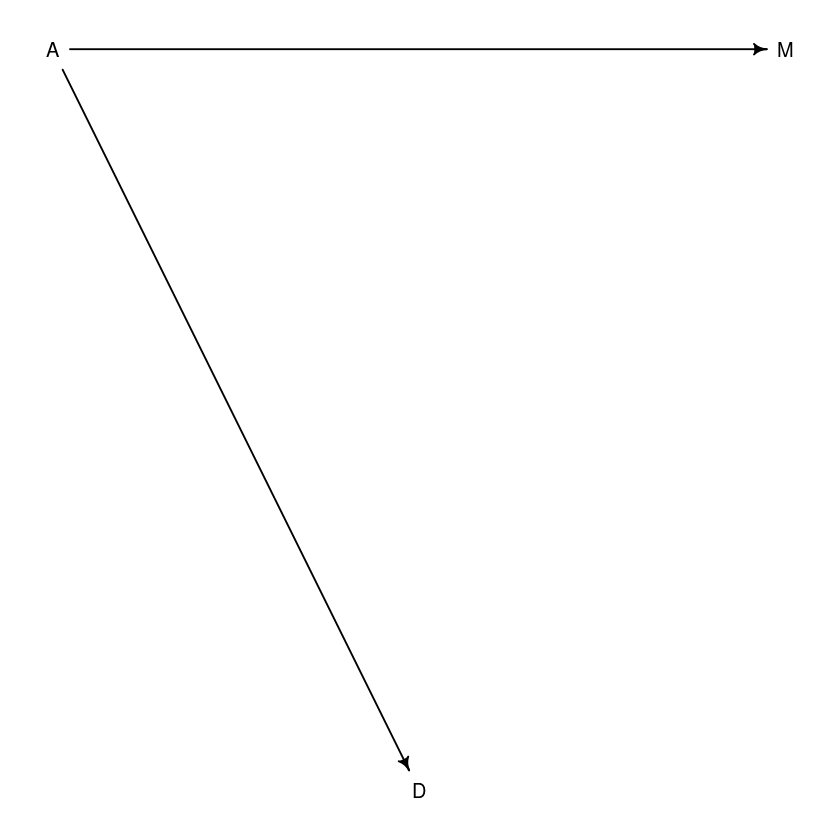

In [37]:
dag5.1 <- dagitty( "dag {
A -> D
A -> M
}")
coordinates(dag5.1) <- list( x=c(A=0,D=1,M=2) , y=c(A=0,D=1,M=0) )
drawdag( dag5.1 )

5.1.2 Testable Implications of each possible Model

For triangle model testable implications:
    + D not independent of A
    + D not independent of M
    + A not independent of M

In [38]:
print(cor(d$D, d$A))
print(cor(d$D, d$M))
print(cor(d$A, d$M))

           [,1]
[1,] -0.5972392
          [,1]
[1,] 0.3737314
          [,1]
[1,] -0.721096


"all 3 pairs are strongly associated" - Are they? What is a threshold for saying there is/is not a correlation?

In [39]:
DMA_dag1 <- dagitty('dag{ D <- A -> M -> D }')
impliedConditionalIndependencies( DMA_dag1 )
# No conditional independencies so no output to display

For 2 prong DAG
    + D not dependent of A
    + A not dpendent of M

In [40]:
DMA_dag2 <- dagitty('dag{ D <- A -> M }')
impliedConditionalIndependencies( DMA_dag2 )

D _||_ M | A

# Multiple Regression Notation
![alt text](images/multi-regression.png "Title")

In [41]:
m5.3 <- quap(
    alist(
        D ~ dnorm(mu, sigma),
        mu <- a + bM*M + bA*A,
        a ~ dnorm(0, 0.2),
        bM ~ dnorm(0, 0.5),
        bA ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ), data=d)
precis(m5.3)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,3.580155e-08,0.09707597,-0.1551461,0.1551462
bM,-6.538099e-02,0.15077295,-0.3063453,0.1755833
bA,-6.135129e-01,0.15098350,-0.8548136,-0.3722121
sigma,7.851174e-01,0.07784324,0.6607088,0.9095259


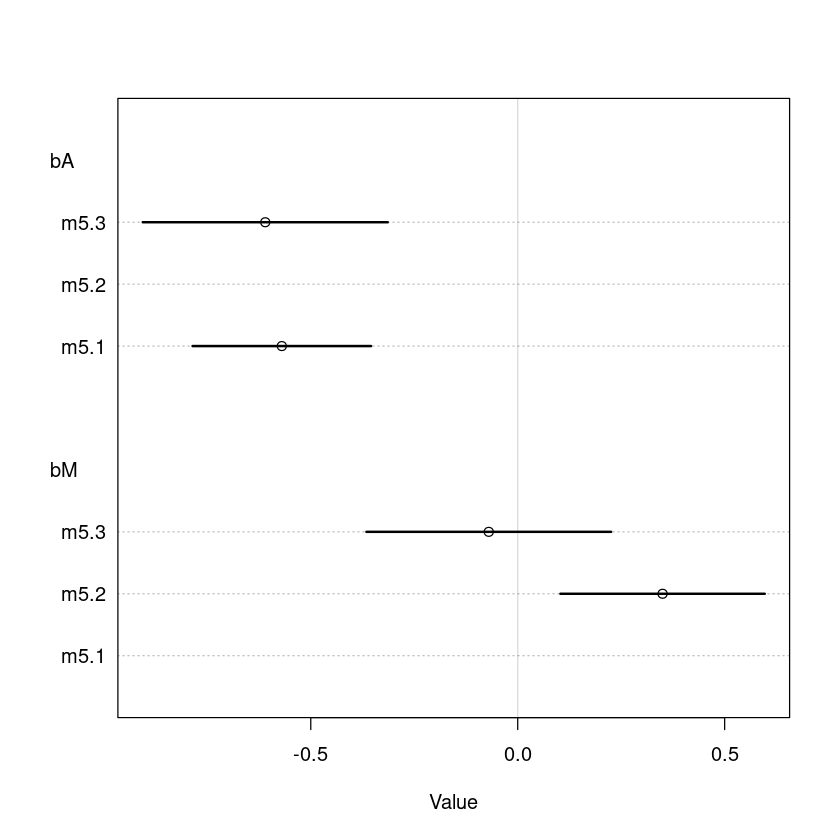

In [42]:
plot( coeftab(m5.1,m5.2,m5.3), par=c("bA","bM") )

**Conclusion**

Once we know median marriage age, there is very little predictive power in knowing the rate of marriage

The first (triangle DAG) did not say this, so it is gone

```I’ll leave it to the reader to investigate the relationship between age at marriage, A, and
marriage rate, M, to complete the picture.```

How?

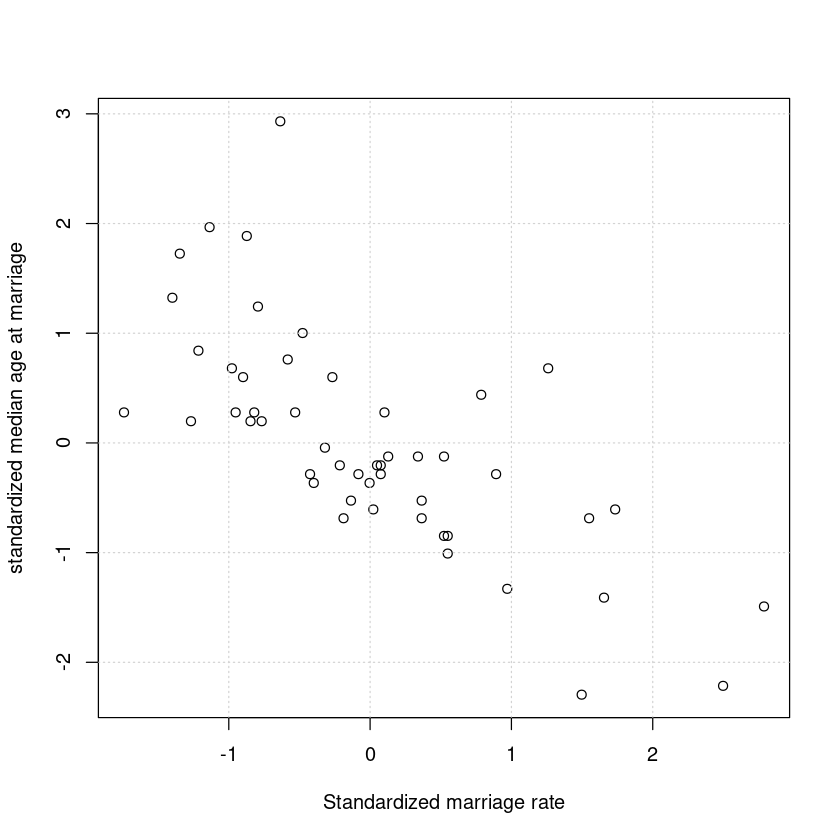

In [43]:
plot(d$M, d$A, xlab='Standardized marriage rate', ylab='standardized median age at marriage')
# abline(lm(d$A ~ d$D))
grid()

### Simulation

In [44]:
N <- 50 # number of simulated States
age <- rnorm( N )
# sim A
mar <- rnorm( N , -age ) # sim A -> M
div <- rnorm( N , age ) # sim A -> D

## 5.1.5 Plotting Multivariate Posteriors

### predictor Residual Plot

+ We have 2 predictors of divorce - age and marriage rate
+ To compute predictor residuals for either we use the other predictor to model it - so we predict age on marriage or marriage on age say with predict marriage using age
+ Then we compute the residuals where residual is predicted marriage rate - observed marriage rate (each state)

In [45]:
m5.4 <- quap(
alist(
M ~ dnorm( mu , sigma ) ,
mu <- a + bAM * A ,
a ~ dnorm( 0 , 0.2 ) ,
bAM ~ dnorm( 0 , 0.5 ) ,
sigma ~ dexp( 1 )
) , data = d )

In [46]:
mu <- link(m5.4)
mu_mean <- apply( mu , 2 , mean )
mu_resid <- d$M - mu_mean
mu_resid

-0.3985752803
1.0728048638
-0.0933579003
0.6761293357
0.1484526213
0.6934343723
0.0680658899
1.0901099004
1.3973734310
-0.6275933984
0.4363649647


In [47]:
mu_resid

-0.3985752803
1.0728048638
-0.0933579003
0.6761293357
0.1484526213
0.6934343723
0.0680658899
1.0901099004
1.3973734310
-0.6275933984
0.4363649647
